# SC2 Post-sort QC

Supports **tetrode** and **mixed** pipelines. Set `PIPELINE_MODE` in the imports cell.
Suggested run order: top to bottom; optional sections are marked.
Group-level diagnostics run when `RUN_TETRODE_CHECKS` is True (default: enabled for both group and mixed modes).


### Imports and setup
Run the next code cell first to initialize imports, paths, and notebook defaults.


In [ ]:
# Imports and shared defaults (run first).
from pathlib import Path
import csv
import json
import runpy
import numpy as np
import matplotlib.pyplot as plt
import sys
import spikeinterface.widgets as sw

# Pipeline mode.
PIPELINE_MODE = 'tetrode'  # 'tetrode' or 'mixed'
FORCE_TETRODE_CHECKS = None  # set True/False to override auto mode
SKIP_NOISY_CELLS = False  # set True to skip heavy/plotting cells
# This gate controls notebook diagnostics/plots only; it does not change pipeline sorting behavior.
RUN_TETRODE_CHECKS = True if FORCE_TETRODE_CHECKS is None else FORCE_TETRODE_CHECKS


# Optional deps (safe if missing).
try:
    import pandas as pd
except Exception:
    pd = None

# User inputs and defaults.
# Resolve project root for notebook execution context.
cwd = Path.cwd().resolve()
if (cwd / 'SpikeSorting').exists():
    PROJECT_ROOT = cwd
elif cwd.name == 'SpikeSorting':
    PROJECT_ROOT = cwd.parent
elif cwd.name == 'Analysis' and cwd.parent.name == 'SpikeSorting':
    PROJECT_ROOT = cwd.parent.parent
else:
    PROJECT_ROOT = cwd
base_spike = PROJECT_ROOT / 'SpikeSorting' if (PROJECT_ROOT / 'SpikeSorting').exists() else PROJECT_ROOT
SC2_OUT = base_spike / 'sc2_outputs'
phy_folder = None  # set to a specific phy export folder
data_path = None   # Open Ephys folder (for mapping / raw comparisons)
stream_name = 'auto'
oe_pick_index = None
OE_PROMPT_SELECT = True
EXPORTED_CHANNEL_LABELS = 'as_exported'  # oe_index | oe_label | as_exported

# Keep synthetic geometry previews aligned with pipeline defaults.
TETRODE_SPACING_DX_UM = 300.0
TETRODE_SPACING_DY_UM = 300.0
TETRODE_PITCH_UM = 20.0

# Placeholders to avoid NameError later.
analyzer = None
sorting = None

def _require(value, name: str):
    if value is None:
        raise ValueError(f'{name} is not set. Update the config cell above and re-run.')
    return value

def get_traces_scaled(recording, start_frame=0, end_frame=None):
    traces = recording.get_traces(start_frame=start_frame, end_frame=end_frame)
    try:
        gains = recording.get_channel_gains()
        offsets = recording.get_channel_offsets()
        if gains is not None:
            traces = traces * np.asarray(gains)[None, :]
        if offsets is not None:
            traces = traces + np.asarray(offsets)[None, :]
    except Exception:
        pass
    return traces

def _load_phy_geometry(phy_folder):
    pos_path = phy_folder / 'channel_positions.npy'
    if not pos_path.exists():
        pos_path = phy_folder / 'channel_locations.npy'
    positions = np.load(pos_path) if pos_path.exists() else None

    labels = None
    ch_ids_path = phy_folder / 'channel_ids.npy'
    if ch_ids_path.exists():
        try:
            labels = np.load(ch_ids_path)
        except Exception:
            labels = None

    groups = None
    groups_path = phy_folder / 'channel_groups.npy'
    if groups_path.exists():
        try:
            groups = np.load(groups_path)
        except Exception:
            groups = None

    return positions, labels, groups, pos_path


def _build_synthetic_positions(channel_groups, dx, dy, pitch):
    if channel_groups is None:
        return None
    unique_groups = sorted({int(g) for g in channel_groups.tolist()})
    if not unique_groups:
        return None
    groups_per_row = max(1, int(np.ceil(np.sqrt(len(unique_groups)))))
    positions = np.zeros((channel_groups.size, 2), dtype=float)
    base = np.array([[0.0, 0.0], [pitch, 0.0], [0.0, pitch], [pitch, pitch]], dtype=float)
    for g_idx, group in enumerate(unique_groups):
        row = g_idx // groups_per_row
        col = g_idx % groups_per_row
        offset = np.array([col * dx, (len(unique_groups) - 1 - row) * dy], dtype=float)
        idxs = np.where(channel_groups == group)[0]
        # Plot-only fallback geometry for readability; does not affect sorter geometry or outputs.
        for slot, ch_i in enumerate(idxs):
            positions[ch_i] = offset + base[slot % base.shape[0]]
    return positions


## Quick status check (mode + flags)


In [ ]:
print(f'PIPELINE_MODE={PIPELINE_MODE} | RUN_TETRODE_CHECKS={RUN_TETRODE_CHECKS} | SKIP_NOISY_CELLS={SKIP_NOISY_CELLS}')


### Select Phy export and Open Ephys root
Expected: a selected `phy_folder` path and (optionally) an OE root.
Note: Open Ephys helpers are defined in the resolve cell below.


In [ ]:
# Select a Phy export folder (uses defaults above).
# Ensure SC2_OUT points at the real sc2_outputs folder if run from a nested cwd.
sc2_candidates = []
try:
    sc2_candidates.append(SC2_OUT)
except Exception:
    SC2_OUT = None

if SC2_OUT is None or not Path(SC2_OUT).exists():
    sc2_candidates = []

base = PROJECT_ROOT
sc2_candidates += [
    base / "SpikeSorting" / "sc2_outputs",
    base / "sc2_outputs",
    base.parent / "SpikeSorting" / "sc2_outputs",
]
for cand in sc2_candidates:
    if cand and Path(cand).exists():
        SC2_OUT = Path(cand)
        break

def find_phy_dirs(base: Path):
    if not base.exists():
        return []
    return sorted(
        [p for p in base.glob('phy_*') if (p / 'channel_ids.npy').exists()],
        key=lambda p: p.stat().st_mtime,
        reverse=True,
    )

pick_index = None  # set to an int to pick a specific export from sorted list
PHY_PROMPT_SELECT = True  # prompt when multiple phy_* exports are found

if phy_folder is None:
    dirs = find_phy_dirs(SC2_OUT)
    if not dirs:
        raise RuntimeError(f'No phy_* exports found under {SC2_OUT}')
    if len(dirs) > 1 and pick_index is None and PHY_PROMPT_SELECT:
        print('Available phy exports:')
        for idx, path in enumerate(dirs):
            print('  [{}] {}'.format(idx, path))
        choice = input('Select phy export index [default 0]: ').strip()
        if choice:
            try:
                pick_index = int(choice)
            except ValueError:
                print('Invalid selection; using [0]')
        else:
            pick_index = 0
    if pick_index is None:
        phy_folder = dirs[0]
    else:
        if 0 <= pick_index < len(dirs):
            phy_folder = dirs[pick_index]
        else:
            print(f'pick_index {pick_index} out of range; using [0]')
            phy_folder = dirs[0]

print('Using phy export:', phy_folder)
# Optional: Open Ephys folder for label/gain checks.
if data_path is None:
    data_path = PROJECT_ROOT / 'SpikeSorting' / 'recordings'
if stream_name == 'auto':
    stream_name = None

# Channel label preference for map checks (optional).
if EXPORTED_CHANNEL_LABELS is None:
    EXPORTED_CHANNEL_LABELS = 'as_exported'


### Resolve Open Ephys folder
Expected: a chosen Open Ephys folder and available stream names (if detected).


In [ ]:
# Resolve Open Ephys folder.
from spikeinterface.extractors import read_openephys
from spikeinterface.extractors.extractor_classes import OpenEphysBinaryRecordingExtractor

def find_oe_recordings(root: Path):
    if not root.exists():
        return []
    if (root / 'structure.oebin').exists():
        return [root]
    return sorted({p.parent for p in root.rglob('structure.oebin')})

def resolve_oe_folder(root: Path, pick_index=None, prompt=False):
    candidates = find_oe_recordings(root)
    if not candidates:
        print(f'No Open Ephys recording folders found under {root}')
        return None
    if len(candidates) > 1:
        print('Available Open Ephys folders:')
        for idx, path in enumerate(candidates):
            print(f'  [{idx}] {path}')
        if pick_index is None and prompt:
            print('Enter the index to select (blank = 0).')
            sys.stdout.flush()
            choice = input('Select Open Ephys folder index [default 0]: ').strip()
            if choice:
                try:
                    pick_index = int(choice)
                except ValueError:
                    print('Invalid selection; using [0]')
            else:
                pick_index = 0
    if pick_index is None:
        return candidates[0]
    if 0 <= pick_index < len(candidates):
        return candidates[pick_index]
    print(f'pick_index {pick_index} out of range; using [0]')
    return candidates[0]

def get_oe_recording(data_path, stream_name=None, oe_pick_index=None, prompt=False):
    if data_path is None:
        print('Set data_path to an Open Ephys folder to enable label checks.')
        return None, None, stream_name, None, None
    root = Path(data_path)
    if not root.exists():
        print(f'Open Ephys Root Not Found: {root}')
        return None, None, stream_name, None, None

    oe_folder = globals().get('oe_folder')
    if oe_folder is None:
        oe_folder = resolve_oe_folder(root, oe_pick_index, prompt)
        if oe_folder:
            print('Using Open Ephys folder:', oe_folder)
    if oe_folder is None:
        return None, None, stream_name, None, None

    if stream_name is None:
        try:
            stream_names, _ = OpenEphysBinaryRecordingExtractor.get_streams(oe_folder)
            print('Available streams:', stream_names)
            if len(stream_names) == 1:
                stream_name = stream_names[0]
            else:
                non_adc = [name for name in stream_names if 'ADC' not in name]
                if non_adc:
                    stream_name = non_adc[0]
                    print(f'Auto-selected stream_name: {stream_name}')
                else:
                    print('Set stream_name explicitly to choose a stream.')
        except Exception as exc:
            print(f'Warning: could not list streams: {exc}')

    recording = read_openephys(oe_folder, stream_name=stream_name)
    oe_ids = list(recording.channel_ids)
    try:
        oe_names = list(recording.get_property('channel_name'))
    except Exception:
        oe_names = None
    return recording, oe_folder, stream_name, oe_ids, oe_names

def resolve_oe_label(raw_idx, oe_ids, oe_names):
    try:
        idx = int(raw_idx)
    except (TypeError, ValueError):
        return str(raw_idx)
    if oe_names and 0 <= idx < len(oe_names):
        return oe_names[idx]
    if oe_ids and 0 <= idx < len(oe_ids):
        return oe_ids[idx]
    return '<out of range>'

oe_folder = None
if data_path and data_path.exists():
    oe_folder = resolve_oe_folder(data_path, oe_pick_index, OE_PROMPT_SELECT)
    if oe_folder:
        print('Using Open Ephys folder:', oe_folder)
else:
    print('Set data_path to an Open Ephys folder to enable label checks.')


### Version snapshot
Print key package versions for reproducibility.


In [ ]:
# Version snapshot.
print('python:', sys.version.split()[0])
print('numpy:', np.__version__)
try:
    import spikeinterface as si
    print('spikeinterface:', getattr(si, '__version__', 'unknown'))
except Exception as exc:
    print('spikeinterface: not available', exc)
try:
    import hdbscan
    print('hdbscan:', getattr(hdbscan, '__version__', 'unknown'))
except Exception as exc:
    print('hdbscan: not available', exc)
try:
    import numba
    print('numba:', getattr(numba, '__version__', 'unknown'))
except Exception as exc:
    print('numba: not available', exc)


In [ ]:
# Environment checks.
import shutil
import subprocess

phy_exe = shutil.which("phy")
if phy_exe:
    try:
        out = subprocess.check_output([phy_exe, "--version"], text=True).strip()
        print("phy (CLI):", out or "available")
    except Exception as exc:
        print("phy (CLI): found but failed:", exc)
else:
    print("phy (CLI): not on PATH (use the newphy2 env if needed)")

try:
    print("pandas:", pd.__version__)
except Exception:
    print("pandas: not available")


### Export file sanity checks
Note: `template_ind.npy` is optional in some exports.
Expected: OK/MISSING status for required files.


In [ ]:
# Group-level diagnostics. Skip when RUN_TETRODE_CHECKS is False.
if SKIP_NOISY_CELLS or not RUN_TETRODE_CHECKS:
    print('Skipping Group-Level Diagnostics Cell (Set RUN_TETRODE_CHECKS=True To Run).')
else:
    # Export file sanity checks.
    required = [
        'spike_times.npy',
        'spike_clusters.npy',
        'templates.npy',
        'channel_ids.npy',
        'channel_groups.npy',
    ]
    optional = [
        'template_ind.npy',
    ]

    for name in required:
        path = phy_folder / name
        print(f'{name}:', 'OK' if path.exists() else 'MISSING')
    for name in optional:
        path = phy_folder / name
        print(f'{name}:', 'OK (optional)' if path.exists() else 'missing (optional)')

    if (phy_folder / 'spike_times.npy').exists() and (phy_folder / 'spike_clusters.npy').exists():
        spike_times = np.load(phy_folder / 'spike_times.npy')
        spike_clusters = np.load(phy_folder / 'spike_clusters.npy')
        print('spike_times:', spike_times.shape, 'spike_clusters:', spike_clusters.shape)
        if spike_times.shape[0] != spike_clusters.shape[0]:
            print('Warning: spike_times and spike_clusters length mismatch')

    if (phy_folder / 'cluster_info.tsv').exists() and (phy_folder / 'spike_clusters.npy').exists():
        spike_clusters = np.load(phy_folder / 'spike_clusters.npy')
        max_cluster = int(spike_clusters.max()) if spike_clusters.size else -1
        print('max cluster id:', max_cluster)

    params_path = phy_folder / 'params.py'
    if params_path.exists():
        text = params_path.read_text()
        for key in ('n_channels', 'sample_rate', 'dtype'):
            for line in text.splitlines():
                if line.strip().startswith(key):
                    print('params', line.strip())
                    break
    else:
        print('params.py Not Found')

    # recording.dat size check (uses params.py if available).
    dat_path = phy_folder / 'recording.dat'
    if params_path.exists() and dat_path.exists():
        try:
            params = {}
            for line in params_path.read_text().splitlines():
                if '=' in line:
                    key, val = line.split('=', 1)
                    params[key.strip()] = val.strip()
            n_channels = int(params.get('n_channels_dat', params.get('n_channels', 0)))
            sample_rate = float(params.get('sample_rate', params.get('sample_rate_dat', 0.0)))
            dtype_str = params.get('dtype', 'float32').strip("'")
            dtype = np.dtype(dtype_str)
            size_bytes = dat_path.stat().st_size
            if n_channels > 0:
                denom = n_channels * dtype.itemsize
                n_samples = size_bytes // denom
                remainder = size_bytes % denom
                print(f'recording.dat size: {size_bytes} bytes -> {n_samples} samples @ {n_channels} ch ({dtype})')
                if remainder:
                    print(f'Warning: recording.dat size has {remainder} extra bytes (unexpected)')
        except Exception as exc:
            print(f'Warning: recording.dat size check failed: {exc}')


### Export integrity checks
Validate alignment of spike_times/spike_clusters/spike_templates.
Expected: matching array lengths (or warnings).


In [ ]:
# Export integrity checks.
spike_times_path = phy_folder / 'spike_times.npy'
spike_clusters_path = phy_folder / 'spike_clusters.npy'
spike_templates_path = phy_folder / 'spike_templates.npy'
templates_path = phy_folder / 'templates.npy'

if spike_times_path.exists() and spike_clusters_path.exists() and spike_templates_path.exists():
    spike_times = np.load(spike_times_path).reshape(-1)
    spike_clusters = np.load(spike_clusters_path).reshape(-1)
    spike_templates = np.load(spike_templates_path).reshape(-1)
    print('spike_times:', spike_times.shape, 'spike_clusters:', spike_clusters.shape, 'spike_templates:', spike_templates.shape)
    if not (spike_times.size == spike_clusters.size == spike_templates.size):
        print('Warning: spike_times/spike_clusters/spike_templates length mismatch')

    if templates_path.exists():
        templates = np.load(templates_path, mmap_mode='r')
        max_template = int(spike_templates.max()) if spike_templates.size else -1
        if max_template >= templates.shape[0]:
            print(f'Warning: spike_templates max {max_template} >= templates count {templates.shape[0]}')
else:
    print('Export integrity check skipped (missing spike_times/spike_clusters/spike_templates).')


### Spike time bounds check
Ensure spike times are within the exported recording length.
Expected: max spike time within bounds (or warning).


In [ ]:
# Spike time bounds check.

spike_times_path = phy_folder / 'spike_times.npy'
if not spike_times_path.exists():
    print('spike_times.npy Not Found; Run Export First.')
elif not params_path.exists():
    print('params.py Not Found; cannot validate spike times.')
else:
    params = runpy.run_path(params_path)
    dat_path = Path(params.get('dat_path', '')) if params.get('dat_path') else None
    n_channels = int(params.get('n_channels_dat', params.get('n_channels', 0)))
    sample_rate = float(params.get('sample_rate', params.get('sample_rate_dat', 0.0)))
    dtype = np.dtype(params.get('dtype', 'float32'))
    if dat_path and dat_path.exists() and n_channels > 0:
        size_bytes = dat_path.stat().st_size
        n_samples = size_bytes // (n_channels * dtype.itemsize)
        spike_times = np.load(spike_times_path).astype(int).ravel()
        max_spike = int(spike_times.max()) if spike_times.size else -1
        if max_spike >= n_samples:
            print(f'Warning: spike_times max {max_spike} exceeds recording length {n_samples}')
        else:
            print(f'spike_times max {max_spike} within recording length {n_samples}')
        if sample_rate > 0:
            print(f'recording duration: {n_samples / sample_rate:.2f}s; max spike at {max_spike / sample_rate:.2f}s')
    else:
        print('Could Not Compute Recording Length (Missing dat_path or n_channels).')


### params.py contents
Print params.py for quick inspection.
Expected: the full params.py text.


In [ ]:
# params.py contents.
params_path = phy_folder / 'params.py'
if params_path.exists():
    print(params_path.read_text())
else:
    print('params.py Not Found')


### Channel IDs, map, and groups
Expected: loaded arrays with dtype/shape and basic length checks.


In [ ]:
# Group-level diagnostics. Skip when RUN_TETRODE_CHECKS is False.
if SKIP_NOISY_CELLS or not RUN_TETRODE_CHECKS:
    print('Skipping Group-Level Diagnostics Cell (Set RUN_TETRODE_CHECKS=True To Run).')
else:
    # Print channel_ids/map/groups.
    def load_and_print(path: Path, name: str):
        if path.exists():
            arr = np.load(path)
            print(f'{name}: dtype={arr.dtype}, shape={arr.shape}')
            print(np.array2string(arr, separator=' ', max_line_width=120))
        else:
            print(f'{name}: Not Found At {path}')

    load_and_print(phy_folder / 'channel_ids.npy', 'channel_ids')
    load_and_print(phy_folder / 'channel_map.npy', 'channel_map')
    load_and_print(phy_folder / 'channel_groups.npy', 'channel_groups')
    load_and_print(phy_folder / 'channel_shanks.npy', 'channel_shanks')

    tsv = phy_folder / 'cluster_channel_group.tsv'
    if tsv.exists():
        print(f'\n{tsv} (first 10 lines):')
        for line in tsv.read_text(encoding='utf-8').splitlines()[:10]:
            print(f'  {line}')
    else:
        print('cluster_channel_group.tsv: Not Found')

    # Channel length checks.
    try:
        ch_ids = np.load(phy_folder / 'channel_ids.npy') if (phy_folder / 'channel_ids.npy').exists() else None
        ch_map = np.load(phy_folder / 'channel_map.npy') if (phy_folder / 'channel_map.npy').exists() else None
        ch_groups = np.load(phy_folder / 'channel_groups.npy') if (phy_folder / 'channel_groups.npy').exists() else None
        lengths = []
        for name, arr in [('channel_ids', ch_ids), ('channel_map', ch_map), ('channel_groups', ch_groups)]:
            if arr is not None:
                lengths.append((name, int(arr.shape[0])))
        if lengths:
            print('channel array lengths:', lengths)
            vals = {l for _, l in lengths}
            if len(vals) > 1:
                print('Warning: channel array lengths differ')
    except Exception as exc:
        print(f'Warning: channel length check failed: {exc}')


### Channel geometry preview
Plot channel positions if available.
Expected: a geometry plot (or a message if missing).


In [ ]:
# Geometry preview (group-level). Skip when RUN_TETRODE_CHECKS is False.
if SKIP_NOISY_CELLS or not RUN_TETRODE_CHECKS:
    print('Skipping geometry preview cell (set RUN_TETRODE_CHECKS=True to run).')
else:
    # Channel geometry preview.

    SHOW_LABELS = False
    LABEL_EVERY = 2
    LABEL_FONTSIZE = 6
    COLOR_BY_GROUP = True
    SHOW_ORIGINAL_LAYOUT = False  # set True to plot original group layout with gaps

    positions, labels_file, groups, pos_path = _load_phy_geometry(phy_folder)

    labels = None
    if 'EXPORTED_CHANNEL_LABELS' in globals() and not isinstance(EXPORTED_CHANNEL_LABELS, str):
        labels = EXPORTED_CHANNEL_LABELS
    if labels is None:
        labels = labels_file

    if positions is not None:
        fig, ax = plt.subplots(figsize=(8, 8))
        if COLOR_BY_GROUP and groups is not None and groups.shape[0] == positions.shape[0]:
            unique_groups = sorted({int(g) for g in groups.tolist()})
            cmap = plt.get_cmap('tab20', max(len(unique_groups), 1))
            colors = [cmap(unique_groups.index(int(g)) % cmap.N) for g in groups]
            ax.scatter(positions[:, 0], positions[:, 1], s=50, c=colors)
            handles = [
                plt.Line2D([0], [0], marker='o', color='none', markerfacecolor=cmap(i), markersize=6, label=str(g))
                for i, g in enumerate(unique_groups)
            ]
            ax.legend(handles=handles, title='group', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        else:
            ax.scatter(positions[:, 0], positions[:, 1], s=50)

        if labels is not None and SHOW_LABELS:
            for idx, ((x, y), label) in enumerate(zip(positions, labels)):
                if LABEL_EVERY and idx % LABEL_EVERY != 0:
                    continue
                ax.text(x, y, str(label), fontsize=LABEL_FONTSIZE, ha='center', va='center')

        x_min, x_max = float(np.min(positions[:, 0])), float(np.max(positions[:, 0]))
        y_min, y_max = float(np.min(positions[:, 1])), float(np.max(positions[:, 1]))
        pad = 0.05 * max(x_max - x_min, y_max - y_min, 1.0)
        ax.set_xlim(x_min - pad, x_max + pad)
        ax.set_ylim(y_min - pad, y_max + pad)

        ax.set_title(f'Channel geometry ({pos_path.name})')
        ax.set_xlabel('um')
        ax.set_ylabel('um')
        ax.set_aspect('equal', adjustable='box')
        ax.invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print('channel_positions.npy Not Found; Export Geometry To Enable This Plot.')

    if SHOW_ORIGINAL_LAYOUT:
        required = [
            phy_folder / 'channel_ids.npy',
            phy_folder / 'channel_groups.npy',
            phy_folder / 'channel_shanks.npy',
        ]
        if not all(p.exists() for p in required):
            print('Original Layout Plot Requires channel_ids.npy, channel_groups.npy, channel_shanks.npy')
        else:
            ch_ids = np.load(phy_folder / 'channel_ids.npy')
            ch_groups = np.load(phy_folder / 'channel_groups.npy')
            unique_groups = sorted({int(g) for g in ch_groups.tolist()})
            groups_per_row = max(1, int(np.ceil(np.sqrt(len(unique_groups)))))
            dx = float(globals().get('TETRODE_SPACING_DX_UM', 300.0))
            dy = float(globals().get('TETRODE_SPACING_DY_UM', 300.0))
            pitch = float(globals().get('TETRODE_PITCH_UM', 20.0))
            positions_full = _build_synthetic_positions(ch_groups, dx, dy, pitch)
            if positions_full is None:
                print('Original Layout Plot: No Groups Found.')
                positions_full = np.zeros((ch_groups.size, 2), dtype=float)

            fig, ax = plt.subplots(figsize=(8, 8))
            if COLOR_BY_GROUP:
                cmap = plt.get_cmap('tab20', max(len(unique_groups), 1))
                colors = [cmap(unique_groups.index(int(g)) % cmap.N) for g in ch_groups]
                ax.scatter(positions_full[:, 0], positions_full[:, 1], s=50, c=colors)
                handles = [
                    plt.Line2D([0], [0], marker='o', color='none', markerfacecolor=cmap(i), markersize=6, label=str(g))
                    for i, g in enumerate(unique_groups)
                ]
                ax.legend(handles=handles, title='group', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
            else:
                ax.scatter(positions_full[:, 0], positions_full[:, 1], s=50)

            if labels is not None and SHOW_LABELS:
                for idx, ((x, y), label) in enumerate(zip(positions_full, labels)):
                    if LABEL_EVERY and idx % LABEL_EVERY != 0:
                        continue
                    ax.text(x, y, str(label), fontsize=LABEL_FONTSIZE, ha='center', va='center')

            ax.set_title('Original group layout (with gaps)')
            ax.set_xlabel('um')
            ax.set_ylabel('um')
            ax.set_aspect('equal', adjustable='box')
            ax.invert_yaxis()
            plt.tight_layout()
            plt.show()



### Map exported channel_ids to Open Ephys labels

If exported channel_ids are numeric they index Open Ephys channel order; if strings they already represent labels.
Labels are derived from OE channel_name when available.
Expected: a printed mapping from exported IDs to OE labels.


In [ ]:
# Map exported channel_ids to Open Ephys labels.

data_path = globals().get('data_path')
stream_name = globals().get('stream_name')
oe_pick_index = globals().get('oe_pick_index')
OE_PROMPT_SELECT = globals().get('OE_PROMPT_SELECT', False)

if 'get_oe_recording' not in globals():
    print('Run the resolve OE folder cell first to enable label checks.')
    oe_recording = None
    oe_ids = None
    oe_names = None
else:
    oe_recording, oe_folder, stream_name, oe_ids, oe_names = get_oe_recording(
        data_path, stream_name=stream_name, oe_pick_index=oe_pick_index, prompt=OE_PROMPT_SELECT
    )

if oe_recording is not None:
    # Preview OE channel index -> name from structure.oebin.
    if oe_ids is not None and oe_names is not None:
        print('OE channel index -> name (first 12):')
        for idx, name in list(zip(oe_ids, oe_names))[:12]:
            print(f'  {idx} -> {name}')

    # Optional: gain/unit sanity check.
    try:
        gains = oe_recording.get_channel_gains() if hasattr(oe_recording, 'get_channel_gains') else None
    except Exception:
        gains = None
    try:
        units = oe_recording.get_channel_units() if hasattr(oe_recording, 'get_channel_units') else None
    except Exception:
        units = None
    gain_prop = False
    try:
        gain_prop = 'gain_to_uV' in oe_recording.get_property_keys()
    except Exception:
        gain_prop = False
    print('gains present:', gains is not None, 'gain_to_uV prop:', gain_prop)
    if gains is not None:
        try:
            print('gains[0:5]:', gains[:5])
        except Exception:
            print('gains:', gains)
    if units is not None:
        try:
            print('units[0:5]:', units[:5])
        except Exception:
            print('units:', units)

    ch_ids_path = phy_folder / 'channel_ids.npy'
    if ch_ids_path.exists():
        export_ids = np.load(ch_ids_path)
        export_labels = [resolve_oe_label(raw_idx, oe_ids, oe_names) for raw_idx in export_ids]
        EXPORTED_CHANNEL_LABELS = export_labels
        print('Exported channel_ids -> OE labels (first 12):')
        for raw_idx, label in zip(export_ids[:12], export_labels[:12]):
            print(f'{raw_idx} = {label}')

        # Full mapping table (Phy index -> export_id -> OE label).
        try:
            mapping_rows = []
            for i, (raw_idx, label) in enumerate(zip(export_ids, export_labels)):
                try:
                    raw_val = raw_idx.item()
                except Exception:
                    raw_val = raw_idx
                mapping_rows.append((i, str(raw_val), str(label)))

            print(f'Exported channel_id mapping ({len(mapping_rows)} total):')
            print('phy_idx | oe_index | oe_label')
            for i, raw_val, label in mapping_rows:
                print(f'{i:>3}: {raw_val} -> {label}')

            WRITE_MAPPING_TSV = False  # set True to save mapping next to export
            if WRITE_MAPPING_TSV:
                tsv_path = phy_folder / 'channel_map_labels.tsv'
                with tsv_path.open('w', encoding='utf-8') as f:
                    f.write('phy_idx\toe_index\toe_label\n')
                    for i, raw_val, label in mapping_rows:
                        f.write(f'{i}\t{raw_val}\t{label}\n')
                print(f'Wrote {tsv_path}')
        except Exception as exc:
            print(f'Channel mapping print skipped: {exc}')
    else:
        print(f'channel_ids.npy not found at {ch_ids_path}')
else:
    print('Set data_path to an Open Ephys folder to map channel_ids to labels.')



### Translate Phy channel IDs to OE labels

Paste Phy channel indices (contiguous export order) and map them back to OE index/label.


In [ ]:
# Translate Phy channel indices (contiguous export order) to OE index/label.
# Edit the list below.
phy_indices = [0, 1, 2]

def _get_export_mapping():
    if "export_ids" in globals() and "export_labels" in globals():
        ids = list(export_ids)
        labels = list(export_labels)
        return ids, labels

    ch_ids_path = phy_folder / "channel_ids.npy"
    if not ch_ids_path.exists():
        print(f"channel_ids.npy not found at {ch_ids_path}")
        return None, None

    ids = list(np.load(ch_ids_path))
    labels = []
    if "oe_ids" in globals() and "oe_names" in globals():
        labels = [resolve_oe_label(raw_idx, oe_ids, oe_names) for raw_idx in ids]
    else:
        labels = [str(raw_idx) for raw_idx in ids]
    return ids, labels

ids, labels = _get_export_mapping()
if ids is None or labels is None:
    print("Run the mapping cell above first.")
else:
    for i in phy_indices:
        try:
            raw_idx = ids[i]
            label = labels[i]
            print(f"phy_idx {i}: oe_index {raw_idx} | oe_label {label}")
        except Exception as exc:
            print(f"phy_idx {i}: lookup failed ({exc})")


### Group -> channel labels
Expected: per-group channel label lists.


In [ ]:
# Group-level diagnostics. Skip when RUN_TETRODE_CHECKS is False.
if SKIP_NOISY_CELLS or not RUN_TETRODE_CHECKS:
    print('Skipping Group-Level Diagnostics Cell (Set RUN_TETRODE_CHECKS=True To Run).')
else:
    # Show group -> channel labels.
    data_path = globals().get('data_path')
    stream_name = globals().get('stream_name')
    oe_pick_index = globals().get('oe_pick_index')
    OE_PROMPT_SELECT = globals().get('OE_PROMPT_SELECT', False)

    if 'get_oe_recording' not in globals():
        print('Run the resolve OE folder cell first to enable label checks.')
        oe_ids = None
        oe_names = None
    else:
        oe_recording, oe_folder, stream_name, oe_ids, oe_names = get_oe_recording(
            data_path, stream_name=stream_name, oe_pick_index=oe_pick_index, prompt=OE_PROMPT_SELECT
        )

    if oe_ids is None:
        print('Set data_path to enable OE label mapping.')
    else:
        groups_path = phy_folder / 'channel_groups.npy'
        ch_ids_path = phy_folder / 'channel_ids.npy'
        if groups_path.exists() and ch_ids_path.exists():
            channel_groups = np.load(groups_path)
            export_ids = np.load(ch_ids_path)
            group_map = {}
            for idx, grp in enumerate(channel_groups):
                label = resolve_oe_label(export_ids[idx], oe_ids, oe_names)
                group_map.setdefault(int(grp), []).append(label)
            for grp in sorted(group_map):
                print(f'group {grp}: {group_map[grp]}')
        else:
            print('Ensure channel_groups.npy/channel_ids.npy exist.')



### Available unit IDs
Print unit IDs available in this export.
Expected: a list of unit IDs.


In [ ]:
# Available unit IDs.
spike_clusters_path = phy_folder / 'spike_clusters.npy'
if spike_clusters_path.exists():
    spike_clusters = np.load(spike_clusters_path).reshape(-1)
    unit_ids = np.unique(spike_clusters)
    print('n_units:', unit_ids.size)
    print('unit_ids (first 50):', unit_ids[:50])
else:
    print('spike_clusters.npy Not Found; Run Export First.')


### Cluster group summary
Count cluster_group.tsv labels (good/mua/unsorted/noise).
Expected: counts per cluster group.


In [ ]:
# Cluster group summary.

tsv = phy_folder / 'cluster_group.tsv'
if not tsv.exists():
    print('cluster_group.tsv Not Found')
else:
    counts = {}
    with tsv.open('r', encoding='utf-8') as f:
        reader = csv.DictReader(f, delimiter='	')
        for row in reader:
            label = row.get('group', 'unknown')
            counts[label] = counts.get(label, 0) + 1
    print('Cluster group counts:')
    for key in sorted(counts):
        print(f'  {key}: {counts[key]}')


### Units overview (counts + peak-channel groups)
Quick summary per group from TSV and template peak channels.
Expected: counts per group and template peak summary.


In [ ]:
# Group-level diagnostics. Skip when RUN_TETRODE_CHECKS is False.
if SKIP_NOISY_CELLS or not RUN_TETRODE_CHECKS:
    print('Skipping Group-Level Diagnostics Cell (Set RUN_TETRODE_CHECKS=True To Run).')
else:
    # Units overview (counts + peak-channel groups).

    spike_clusters_path = phy_folder / 'spike_clusters.npy'
    tsv = phy_folder / 'cluster_channel_group.tsv'
    channel_groups_path = phy_folder / 'channel_groups.npy'
    spike_templates_path = phy_folder / 'spike_templates.npy'
    templates_path = phy_folder / 'templates.npy'
    template_ind_path = phy_folder / 'template_ind.npy'

    if not spike_clusters_path.exists():
        print('spike_clusters.npy Not Found; Run Export First.')
    else:
        spike_clusters = globals().get('spike_clusters')
        unit_ids = globals().get('unit_ids')
        if spike_clusters is None or unit_ids is None:
            spike_clusters = np.load(spike_clusters_path).reshape(-1)
            unit_ids = np.unique(spike_clusters)
        print('n_units:', unit_ids.size)

        # Per-group counts from cluster_channel_group.tsv.
        if tsv.exists():
            cluster_to_group = {}
            with tsv.open('r', encoding='utf-8') as f:
                reader = csv.DictReader(f, delimiter='	')
                for row in reader:
                    try:
                        cluster_id = int(row.get('cluster_id', -1))
                        group_id = int(row.get('channel_group', row.get('group', -1)))
                    except Exception:
                        continue
                    if cluster_id >= 0 and group_id >= 0:
                        cluster_to_group[cluster_id] = group_id
            if cluster_to_group:
                group_counts = {}
                for unit_id in unit_ids:
                    gid = cluster_to_group.get(int(unit_id))
                    if gid is None:
                        continue
                    group_counts[gid] = group_counts.get(gid, 0) + 1
                print('Units Per Group (From cluster_channel_group.tsv):')
                for gid in sorted(group_counts):
                    print(f'  group {gid}: {group_counts[gid]}')
            else:
                print('cluster_channel_group.tsv Empty Or Missing Groups.')
        else:
            print('cluster_channel_group.tsv Not Found.')

        # Per-group counts from template peak channels.
        if channel_groups_path.exists() and spike_templates_path.exists() and templates_path.exists():
            channel_groups = np.load(channel_groups_path)
            spike_templates = np.load(spike_templates_path).reshape(-1).astype(int)
            templates = np.load(templates_path, mmap_mode='r')
            template_ind = np.load(template_ind_path, mmap_mode='r') if template_ind_path.exists() else None

            # template_ind shape check.
            if template_ind is not None:
                if template_ind.ndim != 2 or template_ind.shape[0] != templates.shape[0]:
                    print(f'Warning: template_ind shape {template_ind.shape} does not match templates {templates.shape}')

            max_template = int(spike_templates.max(initial=0))
            factor = max_template + 1
            keys = spike_clusters.astype(np.int64) * factor + spike_templates.astype(np.int64)
            uniq, counts = np.unique(keys, return_counts=True)
            unit_to_template = {}
            for key, cnt in zip(uniq, counts):
                unit = int(key // factor)
                template = int(key % factor)
                prev = unit_to_template.get(unit)
                if prev is None or cnt > prev[1]:
                    unit_to_template[unit] = (template, cnt)

            peak_group_counts = {}
            for unit, (template, _) in unit_to_template.items():
                if template < 0 or template >= templates.shape[0]:
                    continue
                ptp = np.ptp(templates[template], axis=0)
                if ptp.size == 0:
                    continue
                peak_idx = int(np.argmax(ptp))
                if template_ind is not None and template_ind.shape[0] > template and template_ind.shape[1] == ptp.size:
                    peak_chan = int(template_ind[template, peak_idx])
                else:
                    peak_chan = peak_idx
                if peak_chan < 0 or peak_chan >= len(channel_groups):
                    continue
                group_id = int(channel_groups[peak_chan])
                peak_group_counts[group_id] = peak_group_counts.get(group_id, 0) + 1
            if peak_group_counts:
                print('Units Per Group (By Template Peak Channel):')
                for gid in sorted(peak_group_counts):
                    print(f'  group {gid}: {peak_group_counts[gid]}')
            else:
                print('Could Not Compute Peak-Channel Group Counts.')
        else:
            print('Peak-Channel Group Counts Skipped (Missing templates/channel_groups/spike_templates).')


### Map unit -> group -> channels
Expected: per-unit mapping of group and channel labels.


In [ ]:
# Group-level diagnostics. Skip when RUN_TETRODE_CHECKS is False.
if SKIP_NOISY_CELLS or not RUN_TETRODE_CHECKS:
    print('Skipping Group-Level Diagnostics Cell (Set RUN_TETRODE_CHECKS=True To Run).')
else:
    # Map unit -> group -> channels.

    UNIT_ID = 11  # set a unit id to inspect

    tsv = phy_folder / "cluster_channel_group.tsv"
    groups_path = phy_folder / "channel_groups.npy"
    ch_ids_path = phy_folder / "channel_ids.npy"

    if not tsv.exists():
        print("cluster_channel_group.tsv Not Found")
    elif not groups_path.exists() or not ch_ids_path.exists():
        print("channel_groups.npy Or channel_ids.npy Not Found")
    else:
        group_id = None
        with tsv.open("r", encoding="utf-8") as f:
            reader = csv.DictReader(f, delimiter="	")
            for row in reader:
                try:
                    if int(row.get("cluster_id", -1)) == UNIT_ID:
                        group_id = int(row.get("channel_group", -1))
                        break
                except Exception:
                    continue
        if group_id is None:
            print(f"Unit {UNIT_ID} Not Found In cluster_channel_group.tsv")
        else:
            channel_groups = np.load(groups_path)
            export_ids = np.load(ch_ids_path)
            labels = None
            if "EXPORTED_CHANNEL_LABELS" in globals():
                labels = EXPORTED_CHANNEL_LABELS
            if labels is None:
                # Fall back to OE labels if available.
                labels = []
                for raw_idx in export_ids:
                    try:
                        idx = int(raw_idx)
                    except (TypeError, ValueError):
                        labels.append(str(raw_idx))
                        continue
                    label = None
                    if "oe_names" in globals() and oe_names is not None and 0 <= idx < len(oe_names):
                        label = oe_names[idx]
                    elif "oe_ids" in globals() and oe_ids is not None and 0 <= idx < len(oe_ids):
                        label = oe_ids[idx]
                    else:
                        label = str(raw_idx)
                    labels.append(label)
            channels = [labels[i] for i in np.where(channel_groups == group_id)[0]]
            print(f"unit {UNIT_ID} -> group {group_id}")
            print("channels:", channels)


### Check unit group vs template peak channel
Compare each unit's group to its template peak-channel group.


In [ ]:
# Group-level diagnostics. Skip when RUN_TETRODE_CHECKS is False.
if SKIP_NOISY_CELLS or not RUN_TETRODE_CHECKS:
    print('Skipping Group-Level Diagnostics Cell (Set RUN_TETRODE_CHECKS=True To Run).')
else:
    # Check unit group assignment vs template peak channel.

    CHECK_ALL_UNITS = True  # set False to check a single unit
    UNIT_ID = 11  # used when CHECK_ALL_UNITS=False
    MAX_REPORT = 20  # max mismatches to print when CHECK_ALL_UNITS=True

    tsv = phy_folder / "cluster_channel_group.tsv"
    channel_groups_path = phy_folder / "channel_groups.npy"
    channel_ids_path = phy_folder / "channel_ids.npy"
    spike_clusters_path = phy_folder / "spike_clusters.npy"
    spike_templates_path = phy_folder / "spike_templates.npy"
    templates_path = phy_folder / "templates.npy"
    template_ind_path = phy_folder / "template_ind.npy"
    cluster_info_path = phy_folder / "cluster_info.tsv"

    def _load_vec(path):
        arr = np.load(path)
        return arr.reshape(-1)

    def _load_cluster_groups(tsv_path):
        cluster_to_group = {}
        if not tsv_path.exists():
            return cluster_to_group
        with tsv_path.open("r", encoding="utf-8") as f:
            reader = csv.DictReader(f, delimiter="	")
            for row in reader:
                try:
                    cluster_id = int(row.get("cluster_id", -1))
                except Exception:
                    continue
                try:
                    group_id = int(row.get("channel_group", row.get("group", -1)))
                except Exception:
                    group_id = -1
                if cluster_id >= 0 and group_id >= 0:
                    cluster_to_group[cluster_id] = group_id
        return cluster_to_group

    def _map_labels(export_ids, oe_names=None, oe_ids=None):
        labels = []
        for raw_idx in export_ids:
            try:
                idx = int(raw_idx)
            except (TypeError, ValueError):
                labels.append(str(raw_idx))
                continue
            label = None
            if oe_names is not None and 0 <= idx < len(oe_names):
                label = oe_names[idx]
            elif oe_ids is not None and 0 <= idx < len(oe_ids):
                label = oe_ids[idx]
            else:
                label = str(raw_idx)
            labels.append(label)
        return labels

    def _load_template_map(spike_clusters, spike_templates):
        max_template = int(spike_templates.max(initial=0))
        factor = max_template + 1
        keys = spike_clusters.astype(np.int64) * factor + spike_templates.astype(np.int64)
        uniq, counts = np.unique(keys, return_counts=True)
        best = {}
        for key, cnt in zip(uniq, counts):
            cluster = int(key // factor)
            template = int(key % factor)
            prev = best.get(cluster)
            if prev is None or cnt > prev[1]:
                best[cluster] = (template, cnt)
        return {k: v[0] for k, v in best.items()}

    def _peak_channel_for_template(template_id, templates, template_ind):
        if templates is None or template_id is None:
            return None
        if template_id < 0 or template_id >= templates.shape[0]:
            return None
        ptp = np.ptp(templates[template_id], axis=0)
        if ptp.size == 0:
            return None
        peak_idx = int(np.argmax(ptp))
        if template_ind is not None and template_id < template_ind.shape[0]:
            if template_ind.shape[1] == ptp.size:
                return int(template_ind[template_id, peak_idx])
        return peak_idx

    if not channel_groups_path.exists() or not channel_ids_path.exists():
        print("channel_groups.npy Or channel_ids.npy Not Found")
    else:
        channel_groups = np.load(channel_groups_path)
        export_ids = np.load(channel_ids_path)
        labels = None
        if "EXPORTED_CHANNEL_LABELS" in globals():
            labels = EXPORTED_CHANNEL_LABELS
        if labels is None:
            labels = _map_labels(export_ids, globals().get('oe_names'), globals().get('oe_ids'))

        cluster_to_group = _load_cluster_groups(tsv)
        if not cluster_to_group:
            print("cluster_channel_group.tsv Not Found or empty")
        else:
            templates = np.load(templates_path, mmap_mode='r') if templates_path.exists() else None
            template_ind = np.load(template_ind_path, mmap_mode='r') if template_ind_path.exists() else None
            template_map = {}

            if spike_clusters_path.exists() and spike_templates_path.exists():
                spike_clusters = _load_vec(spike_clusters_path)
                spike_templates = _load_vec(spike_templates_path)
                if CHECK_ALL_UNITS:
                    template_map = _load_template_map(spike_clusters, spike_templates)
                else:
                    mask = spike_clusters == UNIT_ID
                    if np.any(mask):
                        templates_for_unit = spike_templates[mask].astype(int)
                        template_map[UNIT_ID] = int(np.bincount(templates_for_unit).argmax())
            elif cluster_info_path.exists():
                with cluster_info_path.open("r", encoding="utf-8") as f:
                    reader = csv.DictReader(f, delimiter="	")
                    for row in reader:
                        try:
                            cluster_id = int(row.get("cluster_id", -1))
                            if "template" in row:
                                template_map[cluster_id] = int(row.get("template"))
                        except Exception:
                            continue

            if CHECK_ALL_UNITS:
                mismatches = []
                for unit_id, group_id in sorted(cluster_to_group.items()):
                    template_id = template_map.get(unit_id)
                    peak_chan = _peak_channel_for_template(template_id, templates, template_ind)
                    if peak_chan is None:
                        continue
                    peak_group = int(channel_groups[peak_chan])
                    peak_label = labels[peak_chan] if peak_chan < len(labels) else peak_chan
                    if group_id != peak_group:
                        mismatches.append((unit_id, group_id, peak_group, peak_label))
                if mismatches:
                    print(f"Group mismatches: {len(mismatches)}")
                    for row in mismatches[:MAX_REPORT]:
                        unit_id, group_id, peak_group, peak_label = row
                        print(f"unit {unit_id}: tsv group {group_id}, peak {peak_label} -> group {peak_group}")
                    if len(mismatches) > MAX_REPORT:
                        print(f"... {len(mismatches) - MAX_REPORT} more")
                else:
                    print("No group mismatches found (based on template peak channel).")
            else:
                group_id = cluster_to_group.get(UNIT_ID)
                template_id = template_map.get(UNIT_ID)
                peak_chan = _peak_channel_for_template(template_id, templates, template_ind)
                if group_id is None:
                    print(f"Unit {UNIT_ID} Not Found In cluster_channel_group.tsv")
                elif peak_chan is None:
                    print(f"Unit {UNIT_ID}: cannot determine peak channel")
                else:
                    peak_group = int(channel_groups[peak_chan])
                    peak_label = labels[peak_chan] if peak_chan < len(labels) else peak_chan
                    print(f"Unit {UNIT_ID}: tsv group {group_id}, peak {peak_label} -> group {peak_group}")
                    if group_id != peak_group:
                        print("Mismatch: unit group assignment may be wrong for this unit.")


### Inspect exported recording.dat
Expected: file size/shape summary (or missing-file notice).


In [ ]:
# Inspect exported recording.dat.
dat_path = phy_folder / 'recording.dat'
params_path = phy_folder / 'params.py'

if dat_path.exists():
    ch_ids = np.load(phy_folder / 'channel_ids.npy')
    n_channels = int(ch_ids.size)

    dtype = np.float32
    if params_path.exists():
        try:
            params = runpy.run_path(params_path)
            dtype = np.dtype(params.get('dtype', 'float32'))
        except Exception as exc:
            print(f'Warning: could not parse dtype from params.py ({exc}); using float32')

    mm = np.memmap(dat_path, dtype=dtype, mode='r')
    n_samples = mm.size // n_channels
    window = min(30000, n_samples)
    X = mm[:n_channels * window].reshape(window, n_channels)
    print('Channels:', n_channels, 'Dtype:', dtype, 'Samples:', X.shape[0])
    print('per-chan std (median):', float(np.median(X.std(axis=0))))
    print('per-chan p2p (median):', float(np.median(np.ptp(X, axis=0))))
    print('global min/max:', float(X.min()), float(X.max()))
    frac_gt500 = float(np.sum(np.abs(X) > 500) / X.size)
    print('fraction |value| > 500 uV:', frac_gt500)
else:
    print('recording.dat Not Found; Run Export First.')



### Compare Open Ephys vs exported .dat
Expected: alignment stats and basic sanity checks.


In [ ]:
# Compare Open Ephys vs exported .dat.
data_path = globals().get('data_path')
stream_name = globals().get('stream_name')
oe_pick_index = globals().get('oe_pick_index')
OE_PROMPT_SELECT = globals().get('OE_PROMPT_SELECT', False)

if 'get_oe_recording' not in globals():
    print('Run the resolve OE folder cell first to enable OE/DAT comparison.')
    oe_recording = None
else:
    oe_recording, oe_folder, stream_name, oe_ids, oe_names = get_oe_recording(
        data_path, stream_name=stream_name, oe_pick_index=oe_pick_index, prompt=OE_PROMPT_SELECT
    )

if oe_recording is not None:
    fs = oe_recording.get_sampling_frequency()
    X_scaled = get_traces_scaled(oe_recording, start_frame=0, end_frame=int(fs))
    print('OE scaled  median std:', np.median(X_scaled.std(axis=0)))
    print('OE scaled  median p2p:', np.median(np.ptp(X_scaled, axis=0)))
    print('OE scaled  min/max:', X_scaled.min(), X_scaled.max())

    dat_path = phy_folder / 'recording.dat'
    params_path = phy_folder / 'params.py'
    if dat_path.exists():
        ch_ids = np.load(phy_folder / 'channel_ids.npy')
        n_channels = int(ch_ids.size)

        dtype = np.float32
        if params_path.exists():
            try:
                params = runpy.run_path(params_path)
                dtype = np.dtype(params.get('dtype', 'float32'))
            except Exception as exc:
                print(f'Warning: could not parse dtype from params.py ({exc}); using float32')

        mm = np.memmap(dat_path, dtype=dtype, mode='r')
        print('DAT dtype:', mm.dtype)
        X_dat = mm[:n_channels * int(fs)].reshape(int(fs), n_channels)
        print('DAT median std:', np.median(X_dat.std(axis=0)))
        print('DAT median p2p:', np.median(np.ptp(X_dat, axis=0)))
        print('DAT min/max:', X_dat.min(), X_dat.max())
    else:
        print('recording.dat Not Found; Run Export First.')
else:
    print('Set data_path to your Open Ephys folder to run this check.')




### QC with SortingAnalyzer
Expected: QC extension outputs and plots (if enabled).


In [ ]:
# QC diagnostics (SortingAnalyzer). Skip when RUN_TETRODE_CHECKS is False.
if SKIP_NOISY_CELLS or not RUN_TETRODE_CHECKS:
    print('Skipping QC diagnostics cell (set RUN_TETRODE_CHECKS=True to run).')
else:
    # QC with SortingAnalyzer (templates/PCs/correlograms/metrics).
    from spikeinterface.extractors import read_phy
    from spikeinterface.core import create_sorting_analyzer
    from spikeinterface.extractors.extractor_classes import BinaryRecordingExtractor

    if 'PROJECT_ROOT' in globals():
        _proj_root = PROJECT_ROOT
    else:
        _proj_root = Path.cwd().resolve().parent
    if str(_proj_root) not in sys.path:
        sys.path.insert(0, str(_proj_root))

    RUN_QC = True  # set True to build analyzer + compute QC extensions
    PLOT_QC = True  # set True to display QC plots in the notebook
    QC_SPARSE = False  # set True to estimate sparsity (probe required; use False for correct group labels)
    MIN_SPIKES_QC = 100  # skip QC metrics for units with fewer spikes (set None to disable)
    AMP_CUTOFF_MIN_SPIKES = 2500  # 500 bins * ratio 5; avoid amplitude_cutoff NaNs
    UNIT_INDEX = 46  # which unit to plot (picked for visible amplitudes)
    PAIR_INDEX = 1  # second unit for cross-correlograms
    PLOT_WF_TIME_AXIS = True  # show waveform grid with time in ms
    WF_CHANNELS = 4  # max channels to plot per unit (mixed mode may map units to 2-ch or 4-ch groups)
    WF_MAX_SPIKES = 80  # smaller subset for cleaner overlay
    WF_ALPHA = 0.05
    WF_USE_UNIT_GROUP = False  # use top-PTP channels for clearer waveforms
    WF_GROUP_MIN_FRAC = 0.4  # only use group channels if strong enough

    if RUN_QC:
        params = runpy.run_path(phy_folder / 'params.py')
        dat_path = Path(params['dat_path'])
        n_channels = int(params.get('n_channels_dat', params.get('n_channels')))
        sample_rate = float(params.get('sample_rate', params.get('sample_rate_dat', 30000.0)))
        dtype = np.dtype(params.get('dtype', 'float32'))

        sorting = read_phy(phy_folder)
        sorting_qc = sorting
        spike_counts_qc = None
        if MIN_SPIKES_QC is not None and MIN_SPIKES_QC > 0:
            if hasattr(sorting, 'count_num_spikes_per_unit'):
                spike_counts = sorting.count_num_spikes_per_unit()
                keep_units = [uid for uid, count in spike_counts.items() if int(count) >= MIN_SPIKES_QC]
                if keep_units:
                    if len(keep_units) < len(sorting.unit_ids):
                        print(f"QC: keeping {len(keep_units)} / {len(sorting.unit_ids)} units with >= {MIN_SPIKES_QC} spikes")
                    spike_counts_qc = {uid: spike_counts[uid] for uid in keep_units if uid in spike_counts}
                    sorting_qc = sorting.select_units(keep_units)
                else:
                    print(f"QC: no units meet MIN_SPIKES_QC={MIN_SPIKES_QC}; keeping all units")
            else:
                print("QC: spike count filter not available; keeping all units")
        if spike_counts_qc is None and hasattr(sorting_qc, 'count_num_spikes_per_unit'):
            try:
                spike_counts_qc = sorting_qc.count_num_spikes_per_unit()
            except Exception:
                spike_counts_qc = None
        try:
            recording = BinaryRecordingExtractor(
                file_paths=[dat_path],
                sampling_frequency=sample_rate,
                num_channels=n_channels,
                dtype=dtype,
            )
        except TypeError:
            recording = BinaryRecordingExtractor(
                file_path=dat_path,
                sampling_frequency=sample_rate,
                num_channels=n_channels,
                dtype=dtype,
            )

        export_labels_for_qc = None
        try:
            if 'EXPORTED_CHANNEL_LABELS' in globals():
                export_labels_for_qc = EXPORTED_CHANNEL_LABELS
        except Exception:
            export_labels_for_qc = None
        if export_labels_for_qc is None:
            ch_ids_path = phy_folder / 'channel_ids.npy'
            if ch_ids_path.exists():
                try:
                    export_ids = np.load(ch_ids_path)
                    export_labels_for_qc = []
                    for raw_idx in export_ids:
                        try:
                            idx = int(raw_idx)
                        except (TypeError, ValueError):
                            export_labels_for_qc.append(str(raw_idx))
                            continue
                        label = None
                        if 'oe_names' in globals() and oe_names is not None and 0 <= idx < len(oe_names):
                            label = oe_names[idx]
                        elif 'oe_ids' in globals() and oe_ids is not None and 0 <= idx < len(oe_ids):
                            label = oe_ids[idx]
                        else:
                            label = str(raw_idx)
                        export_labels_for_qc.append(label)
                except Exception:
                    export_labels_for_qc = None
        EXPORT_LABELS_FOR_QC = export_labels_for_qc
        positions, _, channel_groups_for_geom, pos_path = _load_phy_geometry(phy_folder)
        if positions is None:
            if channel_groups_for_geom is not None:
                dx = float(globals().get('TETRODE_SPACING_DX_UM', 300.0))
                dy = float(globals().get('TETRODE_SPACING_DY_UM', 300.0))
                pitch = float(globals().get('TETRODE_PITCH_UM', 20.0))
                positions = _build_synthetic_positions(channel_groups_for_geom, dx, dy, pitch)
                if positions is not None:
                    print('Warning: channel_positions.npy Not Found; Using Synthetic Group Geometry For QC Plots.')
                else:
                    print('Warning: channel_positions.npy Not Found; Skipping Probe Attach (QC Sparsity/Plots May Be Limited).')
            else:
                print('Warning: channel_positions.npy Not Found; Skipping Probe Attach (QC Sparsity/Plots May Be Limited).')

        if positions is not None:
            try:
                rec_loc = recording.set_channel_locations(positions, in_place=False)
            except TypeError:
                rec_loc = recording.set_channel_locations(positions)
            if rec_loc is not None:
                recording = rec_loc

        probe_attached = False
        if positions is not None:
            try:
                from probeinterface import Probe
                locs = recording.get_channel_locations()
                probe = Probe(ndim=locs.shape[1])
                probe.set_contacts(positions=locs, shapes='circle', shape_params={'radius': 5})
                probe.set_device_channel_indices(np.arange(recording.get_num_channels()))
                recording = recording.set_probe(probe, in_place=False)
                probe_attached = recording.get_probe() is not None
                print('Attached probe from channel locations for QC.')
            except Exception as exc:
                print(f'Warning: could not attach probe for QC analyzer: {exc}')

        if QC_SPARSE and not probe_attached:
            print('QC_SPARSE disabled because no probe is attached.')
            QC_SPARSE = False

        print('QC recording probe attached:', probe_attached)

        # Keep export recording explicit for downstream curation/export cells.
        export_recording = recording

        analyzer = create_sorting_analyzer(
            sorting=sorting_qc,
            recording=recording,
            folder=phy_folder / 'analyzer_qc',
            overwrite=True,
            sparse=QC_SPARSE,
        )
        analyzer.compute('random_spikes')
        analyzer.compute('waveforms')
        analyzer.compute('templates')
        analyzer.compute('correlograms')
        try:
            analyzer.compute('noise_levels')
        except Exception as exc:
            print(f'Noise levels not available: {exc}')
        print('QC analyzer ready:', analyzer.folder if getattr(analyzer, 'folder', None) else 'in-memory')

        try:
            import spikeinterface.qualitymetrics as sqm
            desired_metrics = [
                'snr',
                'isi_violation',
                'firing_rate',
                'presence_ratio',
                'amplitude_cutoff',
            ]
            available = None
            for attr in ('get_quality_metric_list', 'get_quality_metrics_list'):
                func = getattr(sqm, attr, None)
                if callable(func):
                    try:
                        available = func()
                        break
                    except Exception:
                        available = None
            if available:
                metric_names = [m for m in desired_metrics if m in available]
                missing = [m for m in desired_metrics if m not in metric_names]
                if missing:
                    print('Skipping unavailable metrics:', missing)
            else:
                metric_names = desired_metrics
            if metric_names:
                if 'amplitude_cutoff' in metric_names and spike_counts_qc:
                    try:
                        min_spikes = min(int(c) for c in spike_counts_qc.values())
                    except Exception:
                        min_spikes = None
                    if min_spikes is not None and min_spikes < AMP_CUTOFF_MIN_SPIKES:
                        metric_names = [m for m in metric_names if m != 'amplitude_cutoff']
                        print(f"Skipping amplitude_cutoff (min spikes {min_spikes} < {AMP_CUTOFF_MIN_SPIKES}).")
                metrics = sqm.compute_quality_metrics(
                    analyzer,
                    metric_names=metric_names,
                )
                print(metrics.head())
            else:
                print('No quality metrics available for this SI version.')
        except Exception as exc:
            print(f'Quality metrics not available: {exc}')

        if PLOT_QC:
            unit_ids = analyzer.sorting.unit_ids
            if unit_ids.size == 0:
                print('No units to plot.')
            else:
                unit_id = unit_ids[min(UNIT_INDEX, unit_ids.size - 1)]
                unit_group_id = None
                group_channels = None
                if WF_USE_UNIT_GROUP:
                    try:
                        tsv_path = phy_folder / "cluster_channel_group.tsv"
                        groups_path = phy_folder / "channel_groups.npy"
                        if tsv_path.exists() and groups_path.exists():
                            unit_group_id = None
                            with tsv_path.open("r", encoding="utf-8") as f:
                                reader = csv.DictReader(f, delimiter="	")
                                for row in reader:
                                    try:
                                        if int(row.get("cluster_id", -1)) == int(unit_id):
                                            unit_group_id = int(row.get("channel_group", -1))
                                            break
                                    except Exception:
                                        continue
                            if unit_group_id is not None:
                                channel_groups = np.load(groups_path)
                                group_channels = np.where(channel_groups == unit_group_id)[0]
                                if group_channels.size > 0:
                                    labels = None
                                    if "EXPORT_LABELS_FOR_QC" in globals():
                                        labels = EXPORT_LABELS_FOR_QC
                                    if labels is None:
                                        labels = recording.channel_ids
                                    chan_labels = [labels[i] for i in group_channels]
                                    print(f"Unit {unit_id} -> group {unit_group_id} channels: {chan_labels}")
                    except Exception as exc:
                        print(f"Warning: unit-group mapping failed: {exc}")
                unit_sparse_channels = None
                try:
                    sparsity = getattr(analyzer, "sparsity", None)
                    if sparsity is not None:
                        unit_sparse_channels = sparsity.unit_id_to_channel_indices.get(unit_id)
                        if unit_sparse_channels is None:
                            try:
                                unit_sparse_channels = sparsity.unit_id_to_channel_indices.get(int(unit_id))
                            except Exception:
                                unit_sparse_channels = None
                except Exception:
                    unit_sparse_channels = None

                if unit_sparse_channels is not None:
                    if (not WF_USE_UNIT_GROUP) or (group_channels is None):
                        labels = None
                        if "EXPORT_LABELS_FOR_QC" in globals():
                            labels = EXPORT_LABELS_FOR_QC
                        if labels is None:
                            labels = recording.channel_ids
                        chan_labels = [labels[i] for i in unit_sparse_channels]
                        print(f"QC sparsity channels: {chan_labels}")
                if PLOT_WF_TIME_AXIS:
                    try:
                        wf_ext = analyzer.get_extension('waveforms')
                        waveforms = None
                        wf_channel_map = None
                        if QC_SPARSE and unit_sparse_channels is not None:
                            try:
                                waveforms = wf_ext.get_waveforms_one_unit(unit_id)
                                wf_channel_map = np.array(unit_sparse_channels)
                            except Exception:
                                waveforms = None
                                wf_channel_map = None
                        if waveforms is None:
                            try:
                                waveforms = wf_ext.get_waveforms_one_unit(unit_id, force_dense=True)
                            except TypeError:
                                waveforms = wf_ext.get_waveforms_one_unit(unit_id)
                            if waveforms is None:
                                raise RuntimeError('No waveforms returned for unit')
                            wf_channel_map = np.arange(waveforms.shape[2])
                        if waveforms.size == 0:
                            print(f'No waveforms available for unit {unit_id}.')
                        else:
                            n_spikes, n_samples, n_channels = waveforms.shape
                            nbefore = getattr(wf_ext, 'nbefore', None)
                            if nbefore is None:
                                ms_before = getattr(wf_ext, '_params', {}).get('ms_before', 1.0)
                                nbefore = int(round(ms_before * sample_rate / 1000.0))
                            t_ms = (np.arange(n_samples) - nbefore) / sample_rate * 1000.0
                            mean_wf = waveforms.mean(axis=0)
                            ptp = np.ptp(mean_wf, axis=0)
                            ptp_all_max = np.nanmax(ptp) if np.isfinite(ptp).any() else 0.0

                            labels = None
                            if 'EXPORT_LABELS_FOR_QC' in globals():
                                labels = EXPORT_LABELS_FOR_QC
                            if labels is None:
                                labels = recording.channel_ids

                            group_local = None
                            if group_channels is not None and group_channels.size > 0:
                                group_local = np.nonzero(np.isin(wf_channel_map, group_channels))[0]
                                if group_local.size == 0:
                                    group_local = None
                                    if QC_SPARSE:
                                        print('Group Channels Not In Waveform Map; Set QC_SPARSE=False To Plot Group Channels.')

                            sparse_local = None
                            if unit_sparse_channels is not None:
                                sparse_local = np.nonzero(np.isin(wf_channel_map, unit_sparse_channels))[0]
                                if sparse_local.size == 0:
                                    sparse_local = None

                            top_local = None
                            source = 'ptp'
                            if group_local is not None:
                                ptp_group = ptp[group_local]
                                ptp_group_max = np.nanmax(ptp_group) if np.isfinite(ptp_group).any() else 0.0
                                if ptp_all_max > 0 and ptp_group_max >= WF_GROUP_MIN_FRAC * ptp_all_max:
                                    top_local = group_local
                                    source = 'group'
                                    if top_local.size > WF_CHANNELS:
                                        top_local = top_local[np.argsort(ptp_group)[::-1][:WF_CHANNELS]]
                            if top_local is None and sparse_local is not None:
                                top_local = sparse_local
                                source = 'sparse'
                                if top_local.size > WF_CHANNELS:
                                    ptp_sparse = ptp[top_local]
                                    top_local = top_local[np.argsort(ptp_sparse)[::-1][:WF_CHANNELS]]
                            if top_local is None:
                                top_n = min(WF_CHANNELS, n_channels)
                                top_local = np.argsort(ptp)[::-1][:top_n]

                            top_global = np.asarray(wf_channel_map)[top_local]
                            try:
                                print(f"Waveform channels source: {source} -> {[labels[i] for i in top_global]}")
                            except Exception:
                                print(f"Waveform channels source: {source}")

                            try:
                                locs = recording.get_channel_locations()
                                loc_sel = locs[top_global]
                                order = np.lexsort((loc_sel[:, 0], loc_sel[:, 1]))
                                top_local = top_local[order]
                                top_global = top_global[order]
                            except Exception:
                                pass

                            if WF_MAX_SPIKES and n_spikes > WF_MAX_SPIKES:
                                idx = np.random.choice(n_spikes, size=WF_MAX_SPIKES, replace=False)
                                wf_plot = waveforms[idx]
                            else:
                                wf_plot = waveforms
                            ncols = 2
                            nrows = int(np.ceil(top_local.size / ncols))
                            fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(6, 4))
                            axes = np.atleast_1d(axes).reshape(nrows, ncols)
                            for j, ch_local in enumerate(top_local):
                                ax = axes[j // ncols, j % ncols]
                                ax.plot(t_ms, wf_plot[:, :, ch_local].T, color='0.8', alpha=WF_ALPHA, linewidth=0.5)
                                ax.plot(t_ms, mean_wf[:, ch_local], color='tab:blue', linewidth=1.5)
                                ch_label = None
                                try:
                                    if labels is not None and top_global[j] < len(labels):
                                        ch_label = labels[top_global[j]]
                                except Exception:
                                    ch_label = None
                                if ch_label is None:
                                    ch_label = recording.channel_ids[int(top_global[j])]
                                ax.set_title(f"{ch_label}")
                            for j in range(top_local.size, nrows * ncols):
                                axes[j // ncols, j % ncols].axis('off')
                            axes[-1, 0].set_xlabel('Time (ms)')
                            axes[-1, 0].set_ylabel('Amplitude (uV if export scaled)')
                            fig.suptitle(f"Unit {unit_id} waveforms ({source}, top {top_local.size})")
                            plt.show()
                    except Exception as exc:
                        print(f"Manual waveform plot failed: {exc}")

                sw.plot_autocorrelograms(analyzer, unit_ids=[unit_id], window_ms=50, bin_ms=1)
                if unit_ids.size > 1:
                    unit_id_2 = unit_ids[min(PAIR_INDEX, unit_ids.size - 1)]
                    sw.plot_crosscorrelograms(
                        analyzer,
                        unit_ids=[unit_id, unit_id_2],
                        window_ms=50,
                        bin_ms=1,
                        min_similarity_for_correlograms=0,
                    )
    else:
        print('Set RUN_QC=True to build a SortingAnalyzer and compute QC extensions.')




## QC + auto-curation
This section assumes a SortingAnalyzer is loaded (e.g., `analyzer_sc2`).
Run the analyzer load cell (or set `analyzer` manually) before QC/curation.
Expected: QC tables and optional curated export when enabled.


In [ ]:
# QC metrics (requires SortingAnalyzer).
RUN_QC_METRICS = False
QC_METRIC_NAMES = [
    "firing_rate",
    "presence_ratio",
    "isi_violation",
    "snr",
    "amplitude_cutoff",
]

if not RUN_QC_METRICS:
    print("QC metrics skipped; set RUN_QC_METRICS=True to run.")
else:
    try:
        from spikeinterface.qualitymetrics import compute_quality_metrics
    except Exception as exc:
        compute_quality_metrics = None
        print(f"qualitymetrics not available: {exc}")

    analyzer_obj = globals().get("analyzer_sc2") or globals().get("analyzer")
    if analyzer_obj is None:
        print("No analyzer found; load one above or run the pipeline first.")
    elif compute_quality_metrics is None:
        print("qualitymetrics not available; skipping QC metrics.")
    else:
        qm = compute_quality_metrics(analyzer_obj, metric_names=QC_METRIC_NAMES)
        print("QC metrics computed:")
        display(qm.head())


In [ ]:
# Auto-curation (optional): filter units by QC metrics.
RUN_AUTO_CURATION = False
AUTO_CURATION_THRESHOLDS = {
    'snr_min': 5.0,
    'isi_violation_max': 0.5,
    'amplitude_cutoff_max': 0.1,
    'presence_ratio_min': 0.9,
    'firing_rate_min': 0.1,
}

if not RUN_AUTO_CURATION:
    print('Auto-curation skipped; set RUN_AUTO_CURATION=True to run.')
else:
    metrics = globals().get('qm')
    analyzer_obj = globals().get('analyzer_sc2') or globals().get('analyzer')
    if metrics is None:
        print('Auto-Curation Skipped: QC Metrics Not Found (Run QC Cell First).')
    elif analyzer_obj is None:
        print('Auto-curation skipped: no analyzer available.')
    else:
        df = metrics.copy()
        def _col(name):
            for c in df.columns:
                if c == name:
                    return c
            return None
        snr_c = _col('snr')
        isi_c = _col('isi_violation')
        amp_c = _col('amplitude_cutoff')
        pr_c = _col('presence_ratio')
        fr_c = _col('firing_rate')

        mask = np.ones(len(df), dtype=bool)
        if snr_c is not None:
            mask &= df[snr_c].fillna(-np.inf) >= AUTO_CURATION_THRESHOLDS['snr_min']
        if isi_c is not None:
            mask &= df[isi_c].fillna(np.inf) <= AUTO_CURATION_THRESHOLDS['isi_violation_max']
        if amp_c is not None:
            mask &= df[amp_c].fillna(np.inf) <= AUTO_CURATION_THRESHOLDS['amplitude_cutoff_max']
        if pr_c is not None:
            mask &= df[pr_c].fillna(-np.inf) >= AUTO_CURATION_THRESHOLDS['presence_ratio_min']
        if fr_c is not None:
            mask &= df[fr_c].fillna(-np.inf) >= AUTO_CURATION_THRESHOLDS['firing_rate_min']

        keep_ids = df.index[mask].tolist()
        print(f'Auto-curation keeps {len(keep_ids)} / {len(df)} units.')
        curated_analyzer = analyzer_obj.select_units(keep_ids)
        print('Curated analyzer stored as: curated_analyzer')


### Automated curation
Filter units based on QC metrics and export curated sorting.
Expected: curated unit count and export folder (if enabled).


In [ ]:
# Automated curation.
from datetime import datetime
from spikeinterface.exporters import export_to_phy

qm = globals().get("qm", None)
if qm is None:
    qm = globals().get("metrics", None)

curation_sorting = globals().get('sorting')
curation_recording = globals().get('export_recording')

if qm is None or curation_sorting is None or curation_recording is None:
    print("Quality metrics or sorting/export_recording not available for curation. Run QC cell first.")
else:
    # Define thresholds.
    snr_thresh = 2.0
    isi_thresh = 0.4
    amp_cutoff_thresh = 0.2

    snr_col = "snr" if "snr" in qm.columns else None
    isi_col = "isi_violations_ratio" if "isi_violations_ratio" in qm.columns else (
        "isi_violation" if "isi_violation" in qm.columns else None
    )
    amp_col = "amplitude_cutoff" if "amplitude_cutoff" in qm.columns else None

    missing = [
        name for name, col in (("snr", snr_col), ("isi", isi_col), ("amplitude_cutoff", amp_col))
        if col is None
    ]
    if missing:
        print(f"Missing metrics columns: {missing}; skipping automated curation.")
    else:
        good_units = qm[
            (qm[snr_col] > snr_thresh) &
            (qm[isi_col] < isi_thresh) &
            (qm[amp_col] < amp_cutoff_thresh)
        ].index.tolist()

        print(f"Good units: {len(good_units)} out of {len(qm)}")

        if good_units:
            curated_sorting = curation_sorting.select_units(good_units)
            curated_folder = phy_folder.parent / f"phy_curated_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
            export_to_phy(
                curated_sorting,
                recording=curation_recording,
                output_folder=curated_folder,
                remove_if_exists=True,
                copy_binary=True,
                verbose=False,
            )
            print(f"Curated sorting exported to {curated_folder}")
        else:
            print("No units passed thresholds; skipping export.")

print("Automated curation complete.")



### Interactive elements
Browse units and adjust thresholds interactively.
Expected: widgets and interactive plots (if ipywidgets is available).


In [31]:
# Interactive elements (requires ipywidgets).
try:
    import ipywidgets as widgets
    from IPython.display import display
except ImportError:
    print("ipywidgets not installed; skipping interactive elements.")
else:
    qm = globals().get("qm", None)
    if qm is None:
        qm = globals().get("metrics", None)

    if 'sorting' not in locals() or 'analyzer' not in locals():
        print("Run QC cell first to enable interactive elements.")
    else:
        unit_options = [f"Unit {u}" for u in sorting.unit_ids]
        if not unit_options:
            print("No units available for interactive plots.")
        else:
            snr_slider = widgets.FloatSlider(
                value=2.0, min=0.5, max=10.0, step=0.1, description='SNR Threshold:'
            )
            unit_dropdown = widgets.Dropdown(options=unit_options, description='Select Unit:')

            def update_plot(snr_thresh, selected_unit):
                unit_id = int(selected_unit.split()[1])
                if qm is not None and 'snr' in qm.columns:
                    good = qm['snr'] > snr_thresh
                    print(f"Units above SNR {snr_thresh}: {good.sum()}")
                sw.plot_unit_waveforms(analyzer, unit_ids=[unit_id])
                plt.show()

            interactive_plot = widgets.interactive(
                update_plot, snr_thresh=snr_slider, selected_unit=unit_dropdown
            )
            display(interactive_plot)

print("Interactive elements loaded.")


interactive(children=(FloatSlider(value=2.0, description='SNR Threshold:', max=10.0, min=0.5), Dropdown(descri…

Interactive elements loaded.


### Additional visualizations
Waveforms, ISI distributions, and correlograms.
Expected: waveform/ISI/correlogram plots.


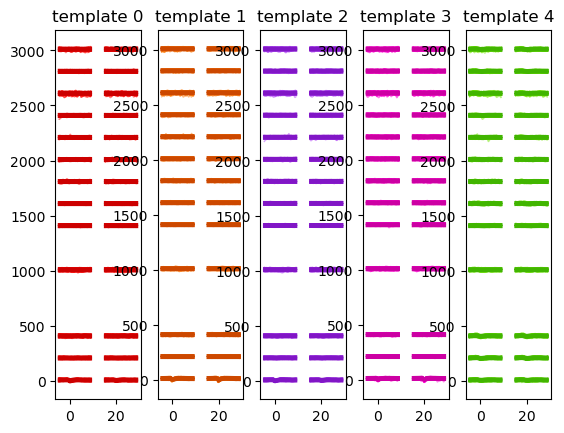

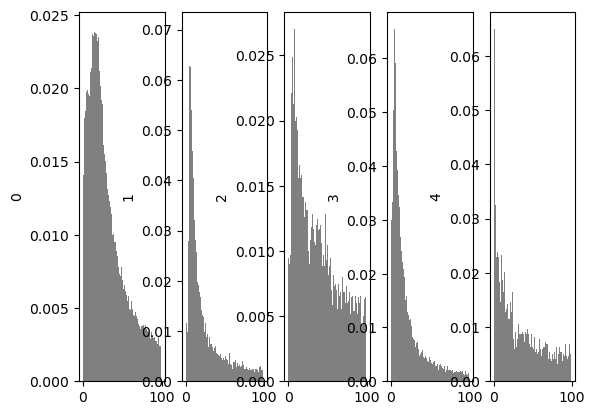

Exception: The template_similarity sorting analyzer extension is required for this widget. Run the `sorting_analyzer.compute('template_similarity', ...)` to compute it.


In [30]:
# Additional visualizations.

if 'analyzer' not in locals() or 'sorting' not in locals():
    print("Run QC cell first to enable additional visualizations.")
else:
    unit_ids = sorting.unit_ids[:5]
    if unit_ids.size == 0:
        print("No units available for waveforms/ISI/correlograms.")
    else:
        sw.plot_unit_waveforms(analyzer, unit_ids=unit_ids)
        plt.show()
        sw.plot_isi_distribution(analyzer, unit_ids=unit_ids, bin_ms=1.0)
        plt.show()
        try:
            sw.plot_crosscorrelograms(
                analyzer,
                unit_ids=unit_ids,
                bin_ms=1.0,
                min_similarity_for_correlograms=0,
            )
            plt.show()
        except Exception as exc:
            print(f"Crosscorrelograms skipped: {exc}")

print("Additional visualizations complete.")


In [ ]:
# Plot units by group with firing rates.
if not RUN_TETRODE_CHECKS:
    print('Skipping Group-Level Plot (Set RUN_TETRODE_CHECKS=True To Run).')
else:

    qm = globals().get("qm", None)
    if qm is None:
        qm = globals().get("metrics", None)

    if qm is None or 'sorting' not in locals():
        print("Quality metrics or sorting not available for group firing rate plot.")
    elif 'firing_rate' not in qm.columns:
        print("firing_rate metric not available; run QC with firing_rate enabled.")
    else:
        tsv_path = phy_folder / "cluster_channel_group.tsv"
        if not tsv_path.exists():
            print("cluster_channel_group.tsv Not Found; skipping group firing rate plot.")
        else:
            unit_to_group = {}
            with tsv_path.open("r", encoding="utf-8") as f:
                reader = csv.DictReader(f, delimiter="	")
                for row in reader:
                    try:
                        unit_to_group[int(row.get("cluster_id", -1))] = int(row.get("channel_group", -1))
                    except Exception:
                        continue

            if not unit_to_group:
                print("No unit->group mapping found; skipping.")
            else:
                group_rates = {}
                for unit in sorting.unit_ids:
                    uid = int(unit)
                    group = unit_to_group.get(uid, None)
                    if group is None:
                        continue
                    if uid in qm.index:
                        rate = qm.loc[uid, 'firing_rate']
                    else:
                        continue
                    group_rates.setdefault(group, []).append(rate)

                if not group_rates:
                    print("No firing rates available for plotting.")
                else:
                    fig, ax = plt.subplots(figsize=(10, 6))
                    group_ids = sorted(group_rates.keys())
                    for gid in group_ids:
                        rates = group_rates[gid]
                        ax.scatter([gid] * len(rates), rates, label=f'Group {gid}', alpha=0.7)
                    ax.set_xlabel('Group')
                    ax.set_ylabel('Firing Rate (Hz)')
                    ax.set_title('Firing Rates by Group')
                    ax.legend()
                    plt.show()

    print("Group firing rate plot complete.")


In [ ]:
# Plot unit locations colored by group.
if not RUN_TETRODE_CHECKS:
    print('Skipping Group-Level Plot (Set RUN_TETRODE_CHECKS=True To Run).')
else:

    if 'analyzer' not in locals():
        print("Run QC cell first to enable unit location plot.")
    else:
        try:
            sw.plot_unit_locations(analyzer, color='group')
            plt.title('Unit Locations Colored by Group')
            plt.show()
        except Exception as e:
            print(f"Could not plot unit locations: {e}")

    print("Unit locations plot complete.")


### Troubleshooting
Common issues and quick fixes for post-sort inspection.

- **No units detected**: Check data quality and detection thresholds.
- **High ISI violations**: Units may be over-merged; consider stricter thresholds or manual curation.
- **Bad channel artifacts**: Update bad channel lists and re-run.
- **Export errors**: Verify Phy install and file permissions.
- **Low SNR**: Improve preprocessing (CAR/filtering) or electrode quality.

For more help, check SpikeInterface docs or GitHub issues.
